# Simulation example with *thztools*

In [1]:
from matplotlib import pyplot as plt
from matplotlib.figure import figaspect

import numpy as np
from numpy import pi
from numpy.fft import rfftfreq, rfft, irfft
from numpy.random import default_rng

import scipy.linalg as la
from scipy import signal
import scipy.optimize as opt
from scipy import stats

import thztools as thz

## Simulate noisy terahertz time-domain waveforms

Functions from `thztools`: `thzgen`, `noiseamp`

The first cell below sets the parameters for the simulation, and the subsequent cell generates `n_sim = 11` noisy terahertz time-domain waveforms, each with `n = 256` samples, and stores them in an `(n_sim, n)` NumPy array `x`. The function `thzgen` returns discrete samples `mu` of an ideal waveform evaluated at the measurement times `t`. The function `noiseamp` returns the noise amplitude `sigma` at each point in the sampled waveform. We use the SciPy `periodogram` function to compute the power spectral density `psd` of each noisy waveform in `x` at the discrete frequencies `f`.

The next cell generates a figure that shows (a) `mu` and `30 * sigma` as a function of `t`; and (b) `psd` as a function of `f`, normalized to the maximum value over the set.

In [2]:
n = 256  # Number of samples
ts = 0.05  # Sampling time [ps]
t0 = 2.5  # Peak pulse time [ps]
fs = 1 / ts  # Sampling frequency [THz]

sigma_alpha = 1e-4  # Additive noise amplitude [signal units]
sigma_beta = 1e-2  # Multiplicative noise amplitude [dimensionless]
sigma_tau = 1e-3  # Time base noise amplitude [ps]
sigma_parms = np.array([sigma_alpha, sigma_beta, sigma_tau])

seed = 0  # RNG seed
rng = default_rng(seed)

In [3]:
mu, t = thz.thzgen(n, ts, t0)
sigma = thz.noiseamp(sigma_parms, mu, ts)

# Use broadcasting to generate multiple simulated noisy measurements of y
n_sim = 11
x = mu + sigma * rng.standard_normal((n_sim, n))

# Compute power spectral density
f, psd = signal.periodogram(x, fs=fs, detrend=False)
n_f = f.size

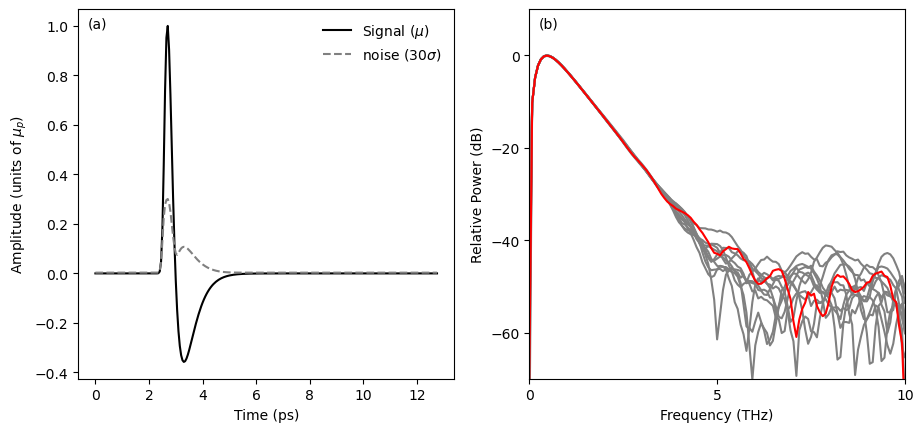

In [4]:
w, h = figaspect(0.45)
_, axs = plt.subplots(1, 2, figsize=(w, h))

axs[0].plot(t, mu, c='k', label=r'Signal ($\mu$)')
axs[0].plot(t, sigma * 30, ls='--', c='grey', label=r'noise $(30 \sigma$)')

axs[0].legend(frameon=False)
axs[0].text(0.025, 0.95, '(a)', transform=axs[0].transAxes)

axs[0].set_xlabel('Time (ps)')
axs[0].set_ylabel(r'Amplitude (units of $\mu_{p})$')

axs[1].plot(f, 10 * np.log10(psd[1:, :].T / max(psd.flatten())), c='grey')
axs[1].plot(f, 10 * np.log10(psd[0, :].T / max(psd.flatten())), c='red')

axs[1].text(0.025, 0.95, '(b)', transform=axs[1].transAxes)

axs[1].set_xlabel('Frequency (THz)')
axs[1].set_ylabel('Relative Power (dB)')

axs[1].set_xticks(np.arange(0, 11, 5))
axs[1].set_xlim(0, 10)
axs[1].set_yticks(np.arange(-60, 10, 20))
axs[1].set_ylim(-70, 10)

plt.show()

## Empirical transfer function estimates

The first cell below simulates `n_sim = 250` pairs of noisy waveforms, `x` and `y`, generated from the same ideal waveforms `mu` and `psi`, respectively, where `psi` is obtained from `mu` by multiplying its amplitude by `0.5` and delaying it by `1.0`. The cell then computes the empirical transfer function estimate `etfe`.

The next cell generates a figure that shows the real (a,c) and the imaginary (b,d) parts of `etfe` as gray dots. One estimate is highlighted in red, with the dots connected by a thin line. Thick black lines indicate the average over all `n_sim = 250` simulations. Panels (a,b) show the full bandwidth and (c,d) show the same data over the primary signal bandwidth.

In [5]:
# Clear x and n_sim for reuse
del x, n_sim

n_sim = 250
p_opt = np.array([0.5, 1.0])
n_p = p_opt.size

f = rfftfreq(n, ts)
def tf_model(_p, _w):
    return _p[0] * np.exp(1j * _w * _p[1])

def td_model(_p, _x):
    _y = irfft(rfft(_x) * tf_model(_p, 2 * pi * f), n=n)
    return _y

psi = td_model(p_opt, mu)

sigma_mu = thz.noiseamp(sigma_parms, mu, ts)
sigma_psi = thz.noiseamp(sigma_parms, psi, ts)

x = mu + sigma_mu * rng.standard_normal((n_sim, n))
y = psi + sigma_psi * rng.standard_normal((n_sim, n))

x_f = np.fft.rfft(x)
y_f = np.fft.rfft(y)
etfe = y_f / x_f

etfe_mean = np.mean(etfe, 0)

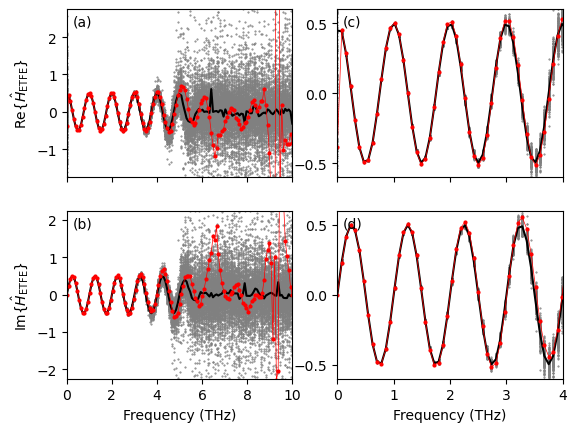

In [6]:
marker_size = 1
marker_size_highlight = 4
line_width_highlight = 0.5
_, axs = plt.subplots(2, 2, sharex='col')

axs[0, 0].plot(f, etfe.real[1:, :].T, '.', ms=marker_size, color='gray')
axs[0, 0].plot(f, etfe_mean.real, 'k-')
axs[0, 0].plot(
    f,
    etfe.real[0, :],
    'r.-',
    ms=marker_size_highlight,
    lw=line_width_highlight,
)

axs[0, 0].text(0.025, 0.9, '(a)', transform=axs[0, 0].transAxes)

axs[1, 0].plot(f, etfe.imag[1:, :].T, '.', ms=marker_size, color='gray')
axs[1, 0].plot(f, etfe_mean.imag, 'k-')
axs[1, 0].plot(
    f,
    etfe.imag[0, :],
    'r.-',
    ms=marker_size_highlight,
    lw=line_width_highlight,
)

axs[1, 0].text(0.025, 0.9, '(b)', transform=axs[1, 0].transAxes)

axs[0, 1].plot(f, etfe.real[1:, :].T, '.', ms=marker_size, color='gray')
axs[0, 1].plot(f, etfe_mean.real, 'k-')
axs[0, 1].plot(
    f,
    etfe.real[0, :],
    'r.-',
    ms=marker_size_highlight,
    lw=line_width_highlight,
)

axs[0, 1].text(0.025, 0.9, '(c)', transform=axs[0, 1].transAxes)

axs[1, 1].plot(f, etfe.imag[1:, :].T, '.', ms=marker_size, color='gray')
axs[1, 1].plot(f, etfe_mean.imag, 'k-')
axs[1, 1].plot(
    f,
    etfe.imag[0, :],
    'r.-',
    ms=marker_size_highlight,
    lw=line_width_highlight,
)

axs[1, 1].text(0.025, 0.9, '(d)', transform=axs[1, 1].transAxes)

axs[0, 0].set_ylim(-1.75, 2.75)
axs[0, 1].set_ylim(-0.6, 0.6)
axs[1, 0].set_ylim(-2.25, 2.25)
axs[1, 1].set_ylim(-0.6, 0.6)

axs[0, 0].set_yticks(np.arange(-1, 3))
axs[0, 1].set_yticks(np.linspace(-0.5, 0.5, 3, endpoint=True))
axs[1, 0].set_yticks(np.arange(-2, 3))
axs[1, 1].set_yticks(np.linspace(-0.5, 0.5, 3, endpoint=True))

axs[0, 0].set_ylabel(r'$\mathrm{Re}\{\hat{H}_\mathrm{ETFE}\}$')
axs[1, 0].set_ylabel(r'$\mathrm{Im}\{\hat{H}_\mathrm{ETFE}\}$')

axs[1, 0].set_xlim(0, 10)
axs[1, 1].set_xlim(0, 4)

axs[1, 0].set_xlabel('Frequency (THz)')
axs[1, 1].set_xlabel('Frequency (THz)')

plt.show()

## Fits to the empirical transfer function estimate

The first cell below defines a transfer function model function `tf_model` and a residual function `res`, then computes the standard deviation of `etfe` as a function of frequency `f`. The transfer function model is
 $$ H(\mathbf{\theta}; \omega) = \theta_0\exp(i\omega\theta_1),$$
 which rescales the input by $\theta_0$ and shifts it by $\theta_1$ (using the $-i\omega t$ sign convention). In the simulations, $\theta_0 = 0.5$ and $\theta_1 = 1$.

The second cell computes the parameter estimates `p_etfe` by performing a weighted least-squares fit to `etfe` with the transfer function model given above. The complex, frequency-domain fit residuals are stored in `residual_etfe` and the sum of the norm-squared residuals over all discrete frequencies is stored in `resnorm_etfe`. Note that `result.cost` returned by the SciPy `least_squares` function is equal to *half* of the sum of the squared residuals over the *given* frequencies, and the given frequencies include just those up to the Nyquist frequency, so we multiply `result.cost` by 4 and adjust for double-counting when `n` is even. The parameter covariance matrix is stored in `cv_etfe`. We use the SciPy `cumfreq` function to obtain the empirical cumulative distribution function `ecdf_etfe` of `resnorm_etfe` at the goodness-of-fit values `gof_etfe`.

The third cell generates a figure that (a) compares the empirical cumulative distribution function `ecdf_etfe` to the $\chi^2$ cumulative distribution function for `n - 2` degrees of freedom and (b) shows the real and imaginary parts of the normalized residuals for a fit that yields `resnorm_etfe` close to the median value. The inset of (a) shows these normalized residuals on a normal probability plot; the gray dashed line shows the standard normal distribution.

The fourth cell compares the observed parameter distribution with the uncertainty estimates obtained from the parameter covariance matrix, and the fifth cell generates histograms of the parameter estimates.

In [7]:
def etfe_res(_p, _f, _etfe, _sigma):
    _r = (_etfe - tf_model(_p, 2 * pi * _f)) / _sigma
    return np.concatenate((_r.real, _r.imag))


sigma_etfe = np.std(etfe, axis=0)

In [8]:
%%time

p_etfe = np.empty((2, n_sim))
resnorm_etfe = np.empty((n_sim,))
residual_etfe = np.empty((n_f, n_sim), dtype=np.complex128)
cv_etfe = np.empty((2, 2, n_sim))
for i in range(n_sim):
    result = opt.least_squares(
        lambda _p: etfe_res(_p, f, etfe[i, :], sigma_etfe), p_opt
    )
    p_etfe[:, i] = result.x
    residual_etfe[:, i] = result.fun[:n_f] + 1j * result.fun[n_f:]
    resnorm_etfe[i] = 4 * result.cost
    if n % 2 == 0:
        resnorm_etfe[i] -= np.abs(residual_etfe[-1, i]) ** 2
    r = np.linalg.qr(result.jac, mode='r')
    r_inv = np.linalg.inv(r)
    cv_etfe[:, :, i] = r_inv @ r_inv.T
    if not result.success:
        print(f"Fit did not converge at i = {i}")

cf = stats.cumfreq(resnorm_etfe, 1000, defaultreallimits=(0, 1000))
gof_etfe = cf.lowerlimit + np.linspace(
    0, cf.binsize * cf.cumcount.size, cf.cumcount.size
)
ecdf_etfe = cf.cumcount / n_sim

CPU times: user 118 ms, sys: 16.5 ms, total: 134 ms
Wall time: 126 ms


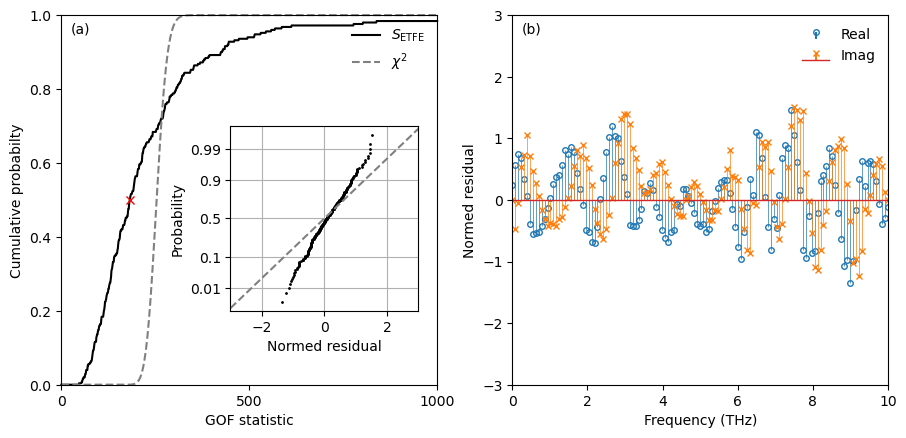

In [9]:
# Find the index of the median value
i_show = np.argsort(resnorm_etfe)[len(resnorm_etfe) // 2]
osm, osr = stats.probplot(
    np.concatenate(
        (residual_etfe[:, i_show].real, residual_etfe[:, i_show].imag)
    ),
    fit=False,
)

w, h = figaspect(0.45)
_, axs = plt.subplots(1, 2, figsize=(w, h))

# Panel (a)
axs[0].plot(
    gof_etfe, ecdf_etfe, 'k-', label=r'$S_\mathrm{ETFE}$', clip_on=False
)
axs[0].plot(
    gof_etfe,
    stats.chi2.cdf(gof_etfe, n - 2),
    '--',
    c='gray',
    label=r'$\chi^2$',
    clip_on=False,
)
axs[0].plot(np.median(resnorm_etfe), 0.5, 'rx')

axs[0].legend(loc='upper right', frameon=False)
axs[0].text(0.025, 0.95, '(a)', transform=axs[0].transAxes)

axs[0].set_xlim(0, 1000)
axs[0].set_ylim(0, 1)

axs[0].set_xticks([0, 500, 1000])
axs[0].set_yticks(np.linspace(0, 1, 6, endpoint=True))

axs[0].set_xlabel('GOF statistic')
axs[0].set_ylabel('Cumulative probabilty')

# Inset to (a)
ins = axs[0].inset_axes([0.45, 0.2, 0.5, 0.5])
ins.plot(osr, osm, 'k.', ms=2)
ins.plot([-3, 3], [-3, 3], '--', c='gray')
ins.grid()

ins.set_xlim(-3, 3)
ins.set_ylim(stats.norm.ppf([0.001, 0.999]))

ins.set_xticks([-2, 0, 2])
ins.set_yticks(stats.norm.ppf([0.01, 0.1, 0.5, 0.9, 0.99]))

ins.set_yticklabels(['0.01', '0.1', '0.5', '0.9', '0.99'])

ins.set_xlabel('Normed residual')
ins.set_ylabel('Probability')

# Panel (b)
markerline, stemlines, baseline = axs[1].stem(
    f,
    residual_etfe[:, i_show].real,
    linefmt='C0-',
    markerfmt='o',
    label='Real',
)
markerline.set_markerfacecolor('none')
markerline.set_markersize(4)
stemlines.set_linewidth(0.5)
baseline.set_linewidth(0)

markerline, stemlines, baseline = axs[1].stem(
    f,
    residual_etfe[:, i_show].imag,
    linefmt='C1-',
    markerfmt='x',
    label='Imag',
)
markerline.set_markersize(4)
markerline.set_linewidth(0.5)
stemlines.set_linewidth(0.5)
baseline.set_linewidth(1)

axs[1].legend(loc='upper right', frameon=False)
axs[1].text(0.025, 0.95, '(b)', transform=axs[1].transAxes)

axs[1].set_xlim(0, 10)
axs[1].set_ylim(-3, 3)

axs[1].set_xlabel('Frequency (THz)')
axs[1].set_ylabel('Normed residual')

plt.show()

In [10]:
print(
    f"Amplitude parameter estimates: "
    f"{np.mean(p_etfe[0, :]):.4f} ± {np.std(p_etfe[0, :]):.4f}"
)
print(
    f"Delay parameter estimates:     "
    f"({np.mean(1e3 * p_etfe[1, :]):.2f} ± {1e3 * np.std(p_etfe[1, :]):.2f}) fs"
)
print(
    f"Mean uncertainty estimate for amplitude parameter: "
    f"{np.mean(np.sqrt(cv_etfe[0, 0, :])):.4f}"
)
print(
    f"Mean uncertainty estimate for delay parameter:     "
    f"{1e3 * np.mean(np.sqrt(cv_etfe[1, 1, :])):.2f} fs"
)
print(
    f"Standard deviation of the amplitude parameter uncertainty estimate: "
    f"{np.std(np.sqrt(cv_etfe[0, 0, :])):.2g}"
)
print(
    f"Standard deviation of the delay parameter uncertainty estimate:     "
    f"{1e3 * np.std(np.sqrt(cv_etfe[1, 1, :])):.2g} fs"
)

Amplitude parameter estimates: 0.4999 ± 0.0022
Delay parameter estimates:     (999.95 ± 0.79) fs
Mean uncertainty estimate for amplitude parameter: 0.0007
Mean uncertainty estimate for delay parameter:     0.26 fs
Standard deviation of the amplitude parameter uncertainty estimate: 2.7e-13
Standard deviation of the delay parameter uncertainty estimate:     0.0011 fs


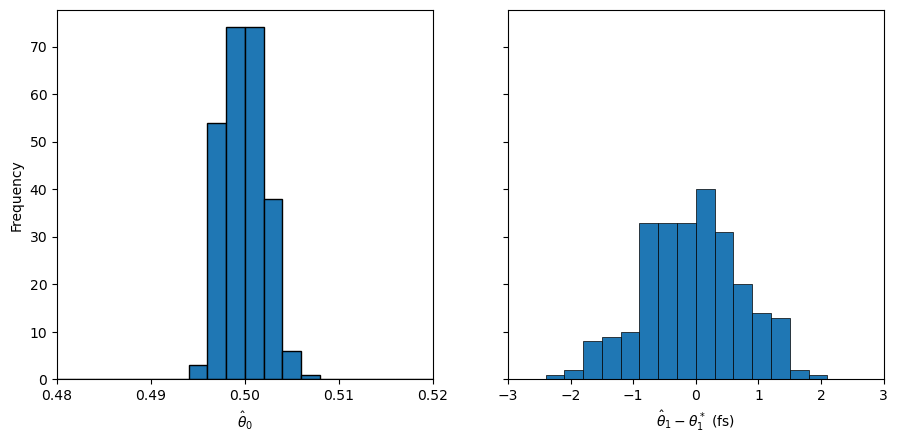

In [11]:
w, h = figaspect(0.45)
_, axs = plt.subplots(1, 2, figsize=(w, h), sharey=True)

axs[0].hist(p_etfe[0, :], bins=20, range=(0.48, 0.52), ec='k')

axs[0].set_xticks(np.arange(0.48, 0.521, 0.01))
axs[0].set_xlim(0.48, 0.52)

axs[0].set_xlabel(r'$\hat{\theta}_0$')
axs[0].set_ylabel('Frequency')

axs[1].hist(1e3 * (p_etfe[1, :] - p_opt[1]), bins=20, range=(-3, 3), ec='k', lw=0.5)

axs[1].set_xticks(np.arange(-3, 3.1, 1))
axs[1].set_xlim(-3, 3)

axs[1].set_xlabel(r'$\hat{\theta}_1 - \theta_1^*$ (fs)')

plt.show()

## Maximum-likelihood transfer function fits

Functions from `thztools`: `costfunlsq`, `fftfreq`

The first cell below fits the transfer function model `tf_model` to the same `x` and `y` data as above, but by optimizing the total-least-squares cost function `costfunlsq` for the time domain, which yields the maximum-likelihood parameter estimates `p_tls`. The time-domain fit residuals are stored in `residual_tls` and the sum of the squared residuals over all time points is stored in `resnorm_tls`. As with the fits to `etfe`, the `result.cost` returned by the SciPy `least_squares` function is equal to *half* of the sum of the squared residuals, so we multiply `result.cost` by 2 to obtain `resnorm_tls`. The parameter covariance matrix is stored in `cv_tls` and `ecdf_tls` is the empirical cumulative distribution function of `resnorm_tls` at the goodness-of-fit values `gof_etfe`.

The second cell generates a figure that (a) compares the empirical cumulative distribution function `ecdf_tls` to the $\chi^2$ cumulative distribution function for `n - 2` degrees of freedom and (b) shows the normalized residuals for a fit that yields `resnorm_tls` close to the median value. The inset of (a) shows these normalized residuals on a normal probability plot; the gray dashed line shows the standard normal distribution.

The third cell compares the observed parameter distribution with the uncertainty estimates obtained from the parameter covariance matrix, and the fourth cell generates histograms of the parameter estimates.

In [12]:
p_tls = np.empty((n_p, n_sim))
resnorm_tls = np.empty((n_sim,))
delta_tls = np.empty((n, n_sim))
epsilon_tls = np.empty((n, n_sim))
cv_tls = np.empty((n_p, n_p, n_sim))
for i in range(n_sim):
    sigma_x = thz.noiseamp(sigma_parms, x[i, :], ts)
    sigma_y = thz.noiseamp(sigma_parms, y[i, :], ts)

    def jac_fun(_x):
        p_est = _x[:n_p]
        mu_est = x[i, :] + _x[n_p:]
        jac_tl = np.zeros((n, n_p))
        jac_tr = np.diag(-1 / sigma_x)
        jac_bl = -(np.stack([
            td_model([1, p_est[1]], mu_est),
            irfft(rfft(mu_est) * (-1j * 2 * pi * f
                                  * tf_model(p_est, 2 * pi * f)),
                  n=n)
        ],
            axis=0) / sigma_y).T
        jac_br = -(
                la.circulant(
                    td_model(p_est, signal.unit_impulse(n))
                ).T  / sigma_y
        ).T
        jac_tot = np.block([[jac_tl, jac_tr], [jac_bl, jac_br]])
        return jac_tot

    result = opt.least_squares(
        lambda _p: thz.costfuntls(
            tf_model, _p[:n_p], x[i, :] + _p[n_p:],
            x[i, :], y[i, :], sigma_x, sigma_y, ts
        ),
        np.concatenate((p_opt, np.zeros(n))),
        jac=jac_fun,
        method='lm',
        x_scale=np.concatenate((np.array([1,1]), sigma_x))
    )
    p_tls[:, i] = result.x[:n_p]
    delta_tls[:, i] = result.fun[:n]
    epsilon_tls[:, i] = result.fun[n:]
    resnorm_tls[i] = 2 * result.cost
    r = np.linalg.qr(result.jac, mode='r')
    r_inv = np.linalg.inv(r)
    cv_tls[:, :, i] = (r_inv @ r_inv.T)[:n_p, :n_p]
    if not result.success:
        print(f"Fit did not converge at i = {i}")

cf_tls = stats.cumfreq(resnorm_tls, 1000, defaultreallimits=(0, 1000))
gof_tls = cf_tls.lowerlimit + np.linspace(
    0, cf_tls.binsize * cf_tls.cumcount.size, cf_tls.cumcount.size
)
ecdf_tls = cf_tls.cumcount / n_sim

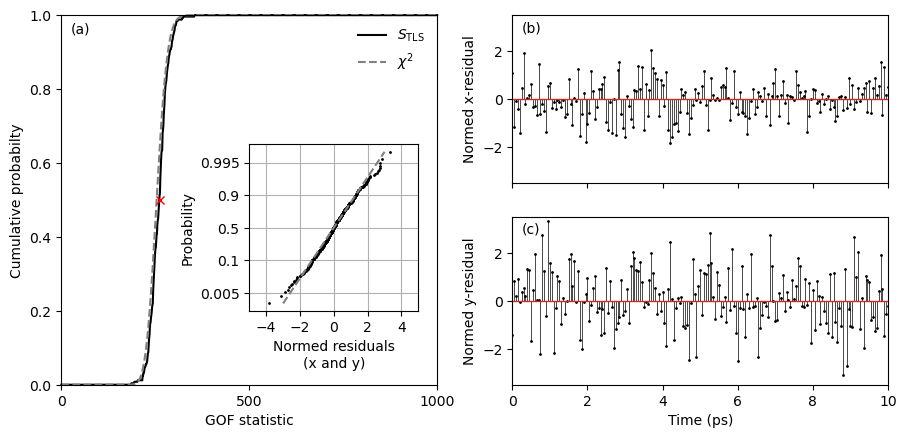

In [13]:
# Find the index of the median value
i_show = np.argsort(resnorm_tls)[len(resnorm_tls) // 2]
norm_res_eps = np.sqrt(512 / 254) * epsilon_tls[:, i_show]
norm_res_delta = np.sqrt(512 / 254) * delta_tls[:, i_show]
osm, osr = stats.probplot(np.concatenate((norm_res_eps, norm_res_delta)), fit=False)

w, h = figaspect(0.45)
_, axd = plt.subplot_mosaic(
    [["CDF", "x-res"], ["CDF", "y-res"]], figsize=(w, h)
)

# Panel (a)
axd["CDF"].plot(
    gof_tls, ecdf_tls, 'k-', label=r'$S_\mathrm{TLS}$', clip_on=False
)
axd["CDF"].plot(
    gof_tls,
    stats.chi2.cdf(gof_tls, n -  n_p),
    '--',
    c='gray',
    label=r'$\chi^2$',
    clip_on=False,
)
axd["CDF"].plot(np.median(resnorm_tls), 0.5, 'rx')

axd["CDF"].legend(loc='upper right', frameon=False)
axd["CDF"].text(0.025, 0.95, '(a)', transform=axd["CDF"].transAxes)

axd["CDF"].set_xlim(0, 1000)
axd["CDF"].set_ylim(0, 1)

axd["CDF"].set_xticks([0, 500, 1000])
axd["CDF"].set_yticks(np.linspace(0, 1, 6, endpoint=True))

axd["CDF"].set_xlabel('GOF statistic')
axd["CDF"].set_ylabel('Cumulative probabilty')

# Inset to (a)
ins = axd["CDF"].inset_axes([0.5, 0.2, 0.45, 0.45])
ins.plot(osr, osm, 'k.', ms=2)
ins.plot([-3, 3], [-3, 3], '--', c='gray')
ins.grid()

ins.set_xlim(-5, 5)
ins.set_ylim(stats.norm.ppf([0.0005, 0.9995]))

ins.set_xticks(np.arange(-4, 4.5, 2))
ins.set_yticks(stats.norm.ppf([0.005, 0.1, 0.5, 0.9, 0.995]))

ins.set_yticklabels(['0.005', '0.1', '0.5', '0.9', '0.995'])

ins.set_xlabel('Normed residuals\n(x and y)')
ins.set_ylabel('Probability')

# Panel (b)
markerline, stemlines, baseline = axd["x-res"].stem(
    t, norm_res_delta, linefmt='k-', markerfmt='.'
)
markerline.set_markersize(2)
stemlines.set_linewidth(0.5)
baseline.set_linewidth(1)

axd["x-res"].text(0.025, 0.9, '(b)', transform=axd["x-res"].transAxes)

axd["x-res"].set_xlim(0, 10)
axd["x-res"].set_ylim(-3.5, 3.5)

axd["x-res"].set_xticklabels([])
axd["x-res"].set_ylabel('Normed x-residual')

# Panel (c)
markerline, stemlines, baseline = axd["y-res"].stem(
    t, norm_res_eps, linefmt='k-', markerfmt='.'
)
markerline.set_markersize(2)
stemlines.set_linewidth(0.5)
baseline.set_linewidth(1)

axd["y-res"].text(0.025, 0.9, '(c)', transform=axd["y-res"].transAxes)

axd["y-res"].set_xlim(0, 10)
axd["y-res"].set_ylim(-3.5, 3.5)

axd["y-res"].set_xlabel('Time (ps)')
axd["y-res"].set_ylabel('Normed y-residual')

plt.show()

In [14]:
print(
    f"Amplitude parameter estimates: "
    f"{np.mean(p_tls[0, :]):.4f} ± {np.std(p_tls[0, :]):.4f}"
)
print(
    f"Delay parameter estimates:     "
    f"({np.mean(1e3 * p_tls[1, :]):.2f} ± {1e3 * np.std(p_tls[1, :]):.2f}) fs"
)
print(
    f"Mean uncertainty estimate for amplitude parameter: "
    f"{np.mean(np.sqrt(cv_tls[0, 0, :])):.4f}"
)
print(
    f"Mean uncertainty estimate for delay parameter:     "
    f"{1e3 * np.mean(np.sqrt(cv_tls[1, 1, :])):.2f} fs"
)
print(
    f"Standard deviation of the amplitude parameter uncertainty estimate: "
    f"{np.std(np.sqrt(cv_tls[0, 0, :])):.2g}"
)
print(
    f"Standard deviation of the delay parameter uncertainty estimate:     "
    f"{1e3 * np.std(np.sqrt(cv_tls[1, 1, :])):.2g} fs"
)

Amplitude parameter estimates: 0.4999 ± 0.0012
Delay parameter estimates:     (1000.04 ± 0.45) fs
Mean uncertainty estimate for amplitude parameter: 0.0012
Mean uncertainty estimate for delay parameter:     0.46 fs
Standard deviation of the amplitude parameter uncertainty estimate: 3.7e-06
Standard deviation of the delay parameter uncertainty estimate:     0.019 fs


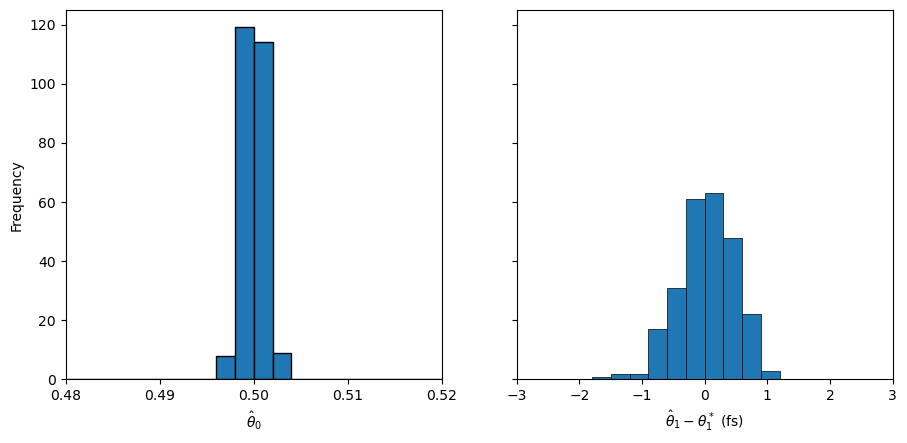

In [15]:
w, h = figaspect(0.45)
_, axs = plt.subplots(1, 2, figsize=(w, h), sharey=True)

axs[0].hist(p_tls[0, :], bins=20, range=(0.48, 0.52), ec='k')

axs[0].set_xticks(np.arange(0.48, 0.521, 0.01))
axs[0].set_xlim(0.48, 0.52)

axs[0].set_xlabel(r'$\hat{\theta}_0$')
axs[0].set_ylabel('Frequency')

axs[1].hist(1e3 * (p_tls[1, :] - p_opt[1]), bins=20, range=(-3, 3), ec='k', lw=0.5)

axs[1].set_xticks(np.arange(-3, 3.1, 1))
axs[1].set_xlim(-3, 3)

axs[1].set_xlabel(r'$\hat{\theta}_1 - \theta_1^*$ (fs)')

plt.show()